# Validation
to make every wine accessible, we train the model again on the full dataset

In [1]:
from IPython.display import display, clear_output
import os
import seaborn as sns
import numpy as np
from importlib import reload
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.stats import gaussian_kde

from wine_utils import WineList, DF_COLUMNS

%matplotlib inline

import warnings
    
warnings.filterwarnings("ignore")

In [2]:
## Import the data in a WineList object
wl = WineList(file='cleaned')
# wl.add_region_variety_stop_words()
# create and store the TaggedDocument list
wl.get_tagged_data()
# import (or retrain) the Doc2Vec model
wl.get_doc2vec_model()

loading tagged_data_set.pkl
loading Doc2Vec model from doc2vec.model


In [3]:
wl.get_kde_argmax(n_min=50)
wl.kde_argmax_vects_dict['Sancerre'].shape

(40,)

In [4]:
wl.get_mean_region_vect_dict(recompute=True)

In [3]:
# Top 10 words most similar to 'simple'
wl.model.most_similar('simple',topn=10)

[('informal', 0.7125917673110962),
 ('fuss', 0.6947001218795776),
 ('easygoing', 0.6764289736747742),
 ('direct', 0.6641587018966675),
 ('casual', 0.6553080081939697),
 ('straightforward', 0.6512728333473206),
 ('charming', 0.6423518657684326),
 ('quaffer', 0.6385226249694824),
 ('nondescript', 0.6279109716415405),
 ('genuine', 0.6259700059890747)]

In [7]:
# Top 10 words most similar to 'smooth'
wl.model.most_similar('smooth',topn=10)

[('soft', 0.7097400426864624),
 ('supple', 0.686550498008728),
 ('satiny', 0.6736397743225098),
 ('round', 0.6655285358428955),
 ('velvety', 0.6583887338638306),
 ('accessible', 0.6254149675369263),
 ('firm', 0.6122607588768005),
 ('soothing', 0.6078168749809265),
 ('glossy', 0.6072683334350586),
 ('network', 0.6060467958450317)]

In [8]:
# Top 10 words most similar to 'lemon'
wl.model.most_similar('lemon',topn=10)

[('curd', 0.8583096265792847),
 ('tangerine', 0.8469404578208923),
 ('lime', 0.8356151580810547),
 ('grapefruit', 0.8181753754615784),
 ('pith', 0.8137401342391968),
 ('pomelo', 0.8118531703948975),
 ('apple', 0.8017528653144836),
 ('pear', 0.8008025884628296),
 ('gravenstein', 0.797846257686615),
 ('peels', 0.7893885374069214)]

In [9]:
# we evaluate the model on regions
column_name = 'region_1'
# count the number of wines in the DataFrame for each region
wl.get_column_cnt_list(column_name)

(1, 10000)

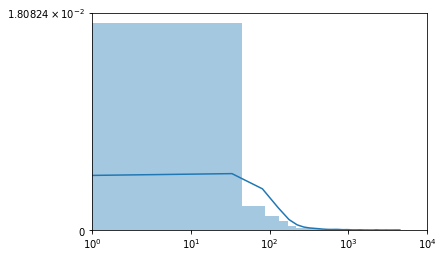

In [10]:
# distribution of wine occurences
sns.distplot([x['count'] for x in wl.column_cnt[column_name]],bins=100)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim([1,10000])

In [5]:
# let's not consider wine regions or varieties that have less than 50 wines
n_min=50
# get the list of regions with more than n_min wines in the DataFrame
top_regions_list = wl.top_regions_list
# top_region_list = [x for x in top_regions]
top_varieties_list = wl.get_top_keys('variety',n_min=50)

In [14]:
# Evaluate how close (cosine) 2 wines from the same region
# within_variety_cosines = []
within_region_cosines = []
random_cosines = []
n_sample = 3000
for n in range(0,n_sample):
    region = random.choice(top_regions_list)
    region_wines = wl.df[wl.df.region_1==region['name']]
    d1,d2 = [row.Index for row in region_wines.sample(n=2).itertuples()]
    within_region_cosines.append(wl.model.docvecs.similarity(d1,d2))
    
#     variety = random.choice(top_varieties_list)
#     variety_wines = wl.df[wl.df.variety==variety['name']]
#     d1,d2 = [row.Index for row in variety_wines.sample(n=2).itertuples()]
#     within_variety_cosines.append(wl.model.docvecs.similarity(d1,d2))    
    
    d1,d2 = [row.Index for row in wl.df.sample(n=2).itertuples()]
    random_cosines.append(wl.model.docvecs.similarity(d1,d2))
    

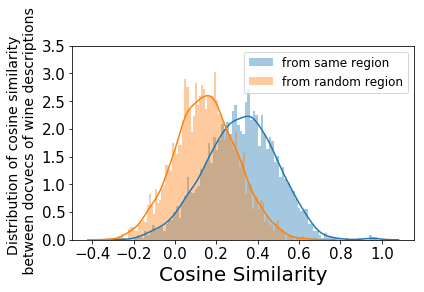

In [15]:
sns.distplot(within_region_cosines,bins=100)
# sns.distplot(within_variety_cosines,bins=100)
sns.distplot(random_cosines,bins=100)
# plt.xlim([0.95,1])
plt.xlabel('Cosine Similarity', fontsize=20)
plt.xticks(fontsize=15)
# plt.title('Wines from the same region have higher \n cosine similarity than wine from random regions', fontsize=14)
plt.ylabel('Distribution of cosine similarities \n between docvecs of wine descriptions', fontsize=14)
plt.yticks(fontsize=15)
plt.legend(['from same region','from random region'], fontsize=12)
plt.ylim([0,3.5])
plt.tight_layout()
plt.savefig('figures/within_across_regions.pdf')
plt.savefig('figures/within_across_regions.png')

## Mean feature vector for each 'top' region
For each region that has more than n_min wines, we compute the mean feature vector.
To save computing time, we'll use only a subset of wines from a region to compute its average wine.
We'll set a threshold to decide whether the average computation is converging.

It turns out that the 'infer_vector' method used to compute a feature vector from a tokenized description provide a non-deterministic results.

Text(0.5, 0, 'Cosine Similarities')

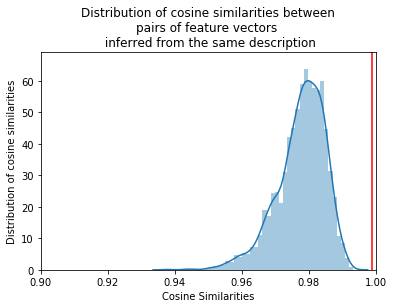

In [16]:
yup = []

for n in range(0,3000):
    desc = wl.tokenize(wl.df.sample(n=1).description.values[0])
    v0 = wl.model.infer_vector(desc).reshape(1,-1)
    v1 = wl.model.infer_vector(desc).reshape(1,-1)
    yup.append(cosine_similarity(v0,v1))

dp_object = sns.distplot(yup)
np.max(dp_object.get_lines()[0].get_data())
y_max = np.max(dp_object.get_lines()[0].get_data())*1.15
plt.xlim([0.9,1])
plt.vlines(0.999,ymin=0,ymax=y_max,color='r')
plt.ylim([0,y_max])
plt.title("Distribution of cosine similarities between\npairs of feature vectors \n inferred from the same description")
plt.ylabel("Distribution of cosine similarities")
plt.xlabel("Cosine Similarities")


In [106]:
wl.get_mean_region_vect_dict()
            

In [21]:
file_name = "mean_region_docvecs_dict.pkl"
with open(file_name, 'wb') as f:
    pickle.dump(wl.mean_vects_dict, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [108]:
# concatenate all the mean vectors into an array
cat_mean_vects = np.concatenate(list(wl.mean_vects_dict.values()),axis=0)

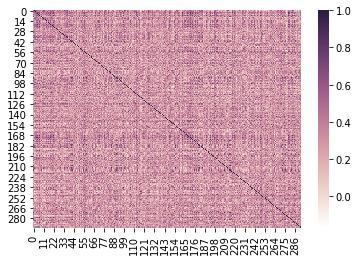

In [109]:
# concatenate all the mean vectors into an array
sim_mat = cosine_similarity(cat_mean_vects)
# let's look at it
sns.heatmap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

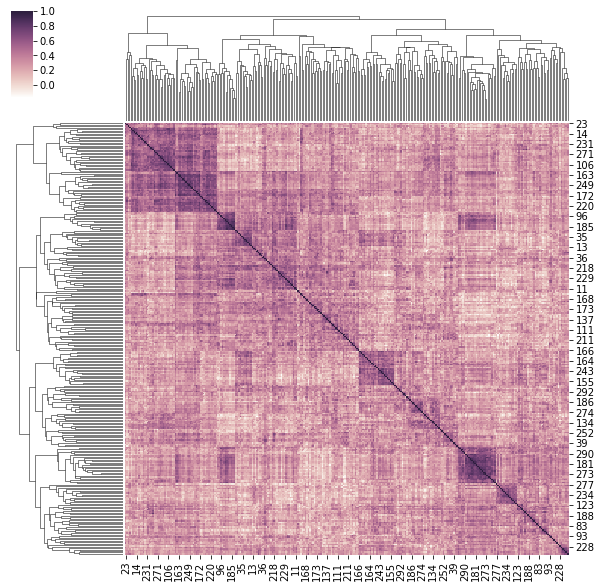

In [110]:
# apply clustermap to see if there is some structure
cg = sns.clustermap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

## Argmax of KDE of feature vectors for each 'top' region
The distribution of feature vectors within a region can have long tails. We're trying to obtain the most stereotypical wine for each region so the mean feature vector might not be the best way to achieve this. Instead let's try to obtain  the location of the maximum density in the feature vector space for each region

In [11]:
# cat_argmax_kde_vects = np.concatenate(list(wl.kde_argmax_vects_dict.values()),axis=1)
cat_argmax_kde_vects = []
for region in top_regions_list:
    cat_argmax_kde_vects.append(wl.kde_argmax_vects_dict[region['name']])
cat_argmax_kde_vects = np.array(cat_argmax_kde_vects)
cat_argmax_kde_vects.shape

(293, 40)

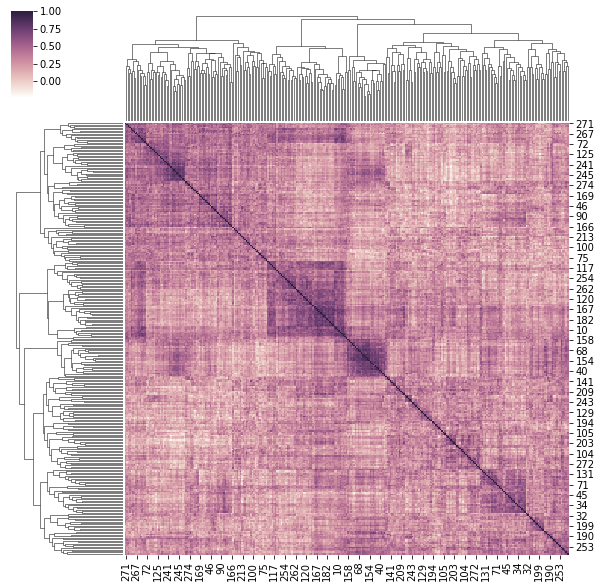

In [12]:
sim_mat = cosine_similarity(cat_argmax_kde_vects)
cg = sns.clustermap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

In [13]:
region_name = 'Sancerre'
similar_docs = wl.model.docvecs.most_similar([wl.kde_argmax_vects_dict[region_name]],topn=10)
similar_docs_indexes = [x[0] for x in similar_docs]
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(similar_docs_indexes)].itertuples()]


Sancerre: 
 From a biodynamic vineyard in the heart of Sancerre, this wine is tight, mineral-driven and very young, well balanced between herbal and citrus flavors. These are lifted and filled out with the ripe Rocha pear flavors that give an extra juicy element. The wine will age well and will be better after 2018.
Sancerre: 
 This wine comes from a single vineyard, planted on flint soil. It has a definite steely character that has been softened by the year in bottle. That gives a pure wine shot through with citrus and apples, showing power and concentration from the intense fruit. Drink the wine now.
Menetou-Salon: 
 Not just old vines, but ancient vines, this is a juicy, concentrated and ripe wine. It is sufficiently rich and textured to need some aging to bring out the full fruits even more. Drink from 2014.
Côtes de Provence: 
 Selected from a portion of the family vineyard, this soft wine, named after the owner of the estate, is gently ripe but with the potential to bring out eve

[None, None, None, None, None, None, None, None, None, None]

## Similarity between regions
Looking at the lowest (resp. highest) values that are not on the diagonal to find pairs of regions that are the most different (resp. similar)

In [14]:
# copy the reordered array
zd_ordered_sim_mat = np.copy(cg.data2d.values)
# set the diagonal values to zero
np.fill_diagonal(zd_ordered_sim_mat,0)

In [15]:
def get_closest_to_average_description(region_1,topn=30):
    """
        a function to display the wine from a region most similar to the average feature vector of that region
    """
    mean_vect = np.array(mean_vects_dict[region_1])
    # find the most similar docsvec for its mean vector
    similar_docs = wl.model.docvecs.most_similar(mean_vect,topn=topn)
    keepgoing = True
    indx = -1
    return_str = "Sorry, we couldn't find anything, consider increasing 'topn'"
    while keepgoing:
        indx+=1
        if wl.df.loc[similar_docs[indx][0]].region_1==region_1:
            keepgoing=False
            return_str = wl.df.loc[similar_docs[indx][0]].description
    return return_str

def get_closest_to_kde_argmax_description(region_1,topn=30):
    """
        a function to display the wine from a region most similar to the average feature vector of that region
    """
    kde_argmax_vect = np.array(wl.kde_argmax_vects_dict[region_1])
    # find the most similar docsvec for its mean vector
    similar_docs = wl.model.docvecs.most_similar([kde_argmax_vect],topn=topn)
    keepgoing = True
    indx = -1
    return_str = "Sorry, we couldn't find anything, consider increasing 'topn'"
    while keepgoing:
        indx+=1
        if wl.df.loc[similar_docs[indx][0]].region_1==region_1:
            keepgoing=False
            return_str = wl.df.loc[similar_docs[indx][0]].description
    return return_str
        

## Sorting pair of wine regions from least to most similar

In [16]:
# indexes of the highest off-diagonal pairs (most similar regions)
ind = np.unravel_index(np.argsort(zd_ordered_sim_mat, axis=None),zd_ordered_sim_mat.shape)
pairs = [[x,y] for x,y in zip(ind[0],ind[1])]
pairs = pairs[::2]

print("A few pairs of very different wines:\n")
for pair in pairs[:5]:
    first_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name']
    second_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[1]]]['name']
    print("{} / {}".format(first_region,second_region))
    
print("\n\nA few pairs of very similar wines:\n")
for pair in pairs[-5:]:
    first_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name']
    second_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[1]]]['name']
    print("{} / {}".format(first_region,second_region))

A few pairs of very different wines:

Oak Knoll District / Fiano di Avellino
Edna Valley / Friuli Grave
Fiano di Avellino / Sonoma County
Santa Ynez Valley / Jumilla
Oak Knoll District / Trento


A few pairs of very similar wines:

Rosso di Montepulciano / Barolo
Rosso di Montepulciano / Barbaresco
Terre Siciliane / Chianti
Barbera d'Asti / Chianti
Barbera d'Asti Superiore / Barbera d'Asti


## Most different wine regions

In [17]:
# corresponding regions
region_0 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[0][0]]]['name']
region_1 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[0][1]]]['name']
print("Wines from '{}' and '{}' are predicted to be very different".format(region_0,region_1))
print(" ")
print("Here are two descriptions:")
get_closest_to_kde_argmax_description(region_0)
print(" ")
get_closest_to_kde_argmax_description(region_1)

Wines from 'Oak Knoll District' and 'Fiano di Avellino' are predicted to be very different
 
Here are two descriptions:
 


"You'll find aromas of dried orchard fruit, beeswax, Spanish broom, acacia and an earthy note on this spry nine-year-old. On the mature, waxy palate, fruit flavors have given way to tertiary sensations of honey, toasted nut, candied citrus zest and flinty mineral that carry through the to lingering finish. A saline note signals the close."

## Most similar wine regions

In [18]:
# indexes of the highest off-diagonal pairs (most similar regions)
# ind = np.unravel_index(np.argmax(zd_ordered_sim_mat, axis=None),zd_ordered_sim_mat.shape)
# corresponding regions
region_0 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[-2][0]]]['name']
region_1 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[-2][1]]]['name']
print("Wines from '{}' and '{}' are predicted to be very similar".format(region_0,region_1))
print(" ")
print("Here are two descriptions:")     
get_closest_to_kde_argmax_description(region_0)
print(" ")
get_closest_to_kde_argmax_description(region_1)

Wines from 'Barbera d'Asti' and 'Chianti' are predicted to be very similar
 
Here are two descriptions:
 


'A blend of 85% Sangiovese, 10% Colorino and 5% Pugnitello, this savory red offers dark berry and blue flower aromas with a whiff of cooking spice. The bright palate displays juicy black cherry, crushed raspberry and a note of ground white pepper alongside smooth tannins. Enjoy soon to capture the fresh fruit flavors.'

# Low dimensional representation of these regions
Each of these regions have many different wines. Let's see if the wines in these regions have very different distributions

In [7]:
region_names = [region['name'] for region in wl.top_regions_list]
regions_df = wl.df[wl.df.region_1.isin([region['name'] for region in wl.top_regions_list])]
regions_docvecs = []
# indexes = {region:[] for region in region_names}
indexes = []
mat_index=-1
names = []

## PCA on feature vectors

In [8]:
# concatenate all the feature vectors for the top regions into an array 
for _, row in regions_df.iterrows():
    if names.count(row.region_1)<n_min:
        mat_index+=1
        # indexes[row.region_1].append(mat_index)
        indexes.append(mat_index)
        names.append(row.region_1)
        regions_docvecs.append(wl.model.infer_vector(row.description))
regions_docvecs = np.array(regions_docvecs)        

In [9]:
print(regions_docvecs.shape)
print(wl.kde_argmax_vects_dict[plot_region].reshape(1,-1).shape)
most_common = pca.transform(wl.kde_argmax_vects_dict[plot_region].reshape(1,-1))[0]
most_common[0]

(14650, 40)


NameError: name 'plot_region' is not defined

Text(0, 0.5, 'Cumulative Variance Ratio for N first PC')

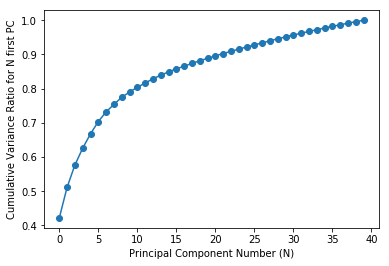

In [13]:
pca = PCA(n_components=40)
y = pca.fit_transform(regions_docvecs)
# y = pca.transform(regions_docvecs)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'o-')
plt.xlabel('Principal Component Number (N)')
plt.ylabel('Cumulative Variance Ratio for N first PC')

In [14]:
# wine region that is the most different from 
for pair in pairs:
    if pair[1]==pairs[-2][0]:
        print(top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name'])
        break

NameError: name 'pairs' is not defined

In [15]:
df_regions = pd.DataFrame(columns=["PCA1","PCA2","name"])
df_regions.PCA1 = y[:,0]
df_regions.PCA2 = y[:,1]
df_regions.name = names
df_regions.head()

,PCA1,PCA2,name
0,0.271041,0.177166,Willamette Valley
1,-0.045308,-0.380486,Willamette Valley
2,-0.227907,0.032935,Navarra
3,1.056546,0.053851,Alsace
4,0.468709,0.019964,Alsace


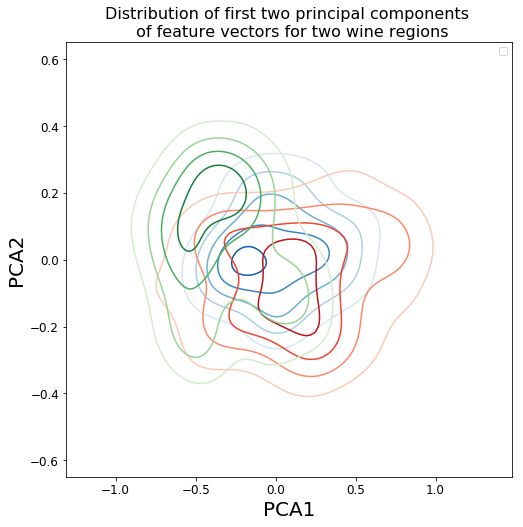

In [16]:
# similar:{'Chianti Rufina':"Blues",'Montefalco Rosso':"Reds"}
# different:{'Cayuga Lake':"Blues",'Fleurie':"Reds"}
# plot_regions_dict = {'Chianti Rufina':"Blues",'Montefalco Rosso':"Reds",'Fleurie':"Greens"}
# 'Mendoza','Côtes de Provence','Barolo'
plot_regions_dict = {'Mendoza':"Blues",'Côtes de Provence':"Reds",'Barolo':"Greens"}

these_regions_list = list(plot_regions_dict.keys())
fig = plt.figure(figsize=(8, 8))

for plot_region in plot_regions_dict.keys():
    sub_df = df_regions[df_regions.name.str.match(plot_region)]
    ax = sns.kdeplot(sub_df.PCA1,sub_df.PCA2,n_levels=5,cmap=plot_regions_dict[plot_region])
    avg_vect = pca.transform(wl.mean_vects_dict[plot_region].copy())[0]    
    
plt.ylabel("PCA2",fontdict={"size":20})
plt.xlabel("PCA1",fontdict={"size":20})
# plt.xlim([-1.1,1.1])
# plt.ylim([-.5,.5])
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
# ax.text(.1, -.4, "Côtes de Provence", size=16, color=red)
# ax.text(-.85, -.3, "Barolo", size=16, color=blue)
plt.legend(plot_regions_dict.keys())
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tight_layout()
plt.title('Distribution of first two principal components \n of feature vectors for two wine regions',fontdict={"size":16})
plt.savefig("figures/PCA_1_2_for_two_wines_{}.pdf".format("_".join([x for x in these_regions_list])), bbox_inches = 'tight')
plt.savefig("figures/PCA_1_2_for_two_wines_{}.png".format("_".join([x for x in these_regions_list])), bbox_inches = 'tight')

In [33]:
avg_vect = pca.transform(wl.mean_vects_dict[plot_region].copy())[0]
avg_vect[1]

0.3350057938665296

## Prices distribution

Text(0.5, 0, 'log10 of price')

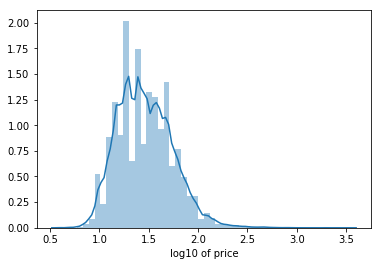

In [268]:
sns.distplot(np.log10(wl.df.price))
plt.xlabel("log10 of price")

# Regional wine suggestions
### Using average and mode


In [16]:
wl.get_mean_region_vect_dict()

In [18]:
region = "Pouilly-Fumé"
topn = 10
additonal_desc = ['plum']
mean_vect = wl.mean_vects_dict[region].copy().reshape(1,-1)
kde_argmax_vect = wl.kde_argmax_vects_dict[region].copy().reshape(1,-1)


### Get the most average wine from 'region'
The average feature vector for wines from the same region doesn't correspond to an existing wine in the DataFrame.
Here we select the wine from the region the most similar to the average.


In [25]:
average_from_region = wl.get_regional_archetype(region,topn=30,method='mean')
print("Average '" + region +"': \n")
print(average_from_region.title.replace("({})".format(region),""))
print(average_from_region.description)
print(" ")
kde_argmax_from_region = wl.get_regional_archetype(region,topn=30,method='kde_mode')
print("KDE mode '" + region +"': \n")
print(kde_argmax_from_region.title.replace("({})".format(region),""))
print(kde_argmax_from_region.description)

Average 'Pouilly-Fumé': 

Château de Tracy 2010  Pouilly-Fumé
An intensely herbal and ageworthy wine, this has tight acidity and a very fresh gooseberry character. With its intensity of flavor, it has something in common with New World Sauvignon Blanc—except this has terroir-driven minerality on the finish.
 
KDE mode 'Pouilly-Fumé': 

Château de Tracy 2005  Pouilly-Fumé
A foursquare wine, all angles and edges, that still needs time to soften and open. It is going to be rich and delicious, hinting at white currants, pears and green plum skins. The minerality and vegetal edge is there as well. An impressive wine from this ancient property.


### Get the 5 wines most similar to the region's average wine 
This will most likely be the same as the previous one

In [20]:
similar_docs = wl.model.docvecs.most_similar(mean_vect,topn=5)
similar_docs_indexes = [x[0] for x in similar_docs]
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(similar_docs_indexes)].itertuples()]

Saint-Bris: 
 Not far from Chablis, there is an enclave of Sauvignon Blanc in Saint-Bris. The wine is properly herbal, very fresh and citrusy. It has a definite animal flavor, tight and crisp to finish.
Champagne: 
 Although not labelled as a Blanc de Blancs, this pure Chardonnay wine is exactly that. It is a floral wine with roundness that comes from the wood vinification. Crisp citrus and green apples push the wine forward along with the acidity and fresh, mineral aftertaste.
California: 
 One of the first wines to be released from the 2011 vintage, this Sauvignon Blanc shows how chilly the year was. It's barely ripe, showing dry, acidic citrus and mineral flavors, with a green, minty edge.
Touraine: 
 Pure Sauvignon Blanc, this is herbal while also crisp, very fruity, bright and lively. Gooseberry juice dominates this intense wine.
Pouilly-Fumé: 
 An intensely herbal and ageworthy wine, this has tight acidity and a very fresh gooseberry character. With its intensity of flavor, it ha

[None, None, None, None, None]

### Same for KDE mode


In [30]:
similar_docs = wl.model.docvecs.most_similar(kde_argmax_vect,topn=5)
similar_docs
similar_docs_indexes = [x[0] for x in similar_docs]
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(similar_docs_indexes)].itertuples()]

Champagne: 
 While the Larmandier's main vineyard is in Vertus, they also have a parcel in the grand cru vineyard of Cramant. It is full of beautifully ripe fruit, beginning to round out as it ages. Green fruits and white pears, as well as yeast are still dominant; drink 2010.
Pouilly-Fumé: 
 A foursquare wine, all angles and edges, that still needs time to soften and open. It is going to be rich and delicious, hinting at white currants, pears and green plum skins. The minerality and vegetal edge is there as well. An impressive wine from this ancient property.
Bordeaux: 
 Firm, dry tannins behind this wine give a hard edge that will need time. The wine is powered by its structure, solid and only just fruity. Wait until at least 2017 to allow more fruitiness to come through, although the wine will likely always be tough.
Bordeaux: 
 From vineyards in the Entre-deux-Mers region of Bordeaux, this Fontana family wine has a dry core surrounded by ripe, fresh fruit. It is still young and sho

[None, None, None, None, None]

# Adding descriptors to average regional wine
Here we check if we can get meaningful answers by added a descriptor to an average regional wine.
The idea is to, for instance, allow to search for a Sancerre with notes of "plum". Such a wine might not be a 'Sancerre' but it should retain the basic characteristics of a Sancerre and have some plum notes.

### 1. Appending a token to a description
Here we obtain the tokenized description of the average wine, append the neew token to it and infer the new feature vector. Wee then display 5 wine most similar to the result

In [24]:
avg_desc = wl.tokenize(average_from_region.description)+additonal_desc
average_vec_with_add_desc = wl.model.infer_vector(avg_desc)
most_similar_to_average = [x[0] for x in wl.model.docvecs.most_similar([average_vec_with_add_desc],topn=10)]
[print("{} / {}: \n {}\n".format(x.region_1,x.title,x.description)) for x in wl.df[wl.df.index.isin(most_similar_to_average)].itertuples()]

Bergerac Sec / Château de la Jaubertie 2010 Mirabelle de la Jaubertie White (Bergerac Sec): 
 This wood-aged wine shows equal notes of toasty spice and ripe fruit. On the palate, it's full and round, with pear and apricot flavors giving it richness. This is concentrated and worth aging for another 2–3 years.

Oak Knoll District / Trefethen 2011 Chardonnay (Oak Knoll District): 
 A fine Chardonnay, front-loaded with tropical fruit, Asian pear, and green apple flavors, with rich honey and vanilla from charred oak barrels. With a crunch of acidity, it's Trefethen's best Chardonnay in years.

Russian River Valley / Romililly 2012 Chardonnay (Russian River Valley): 
 The buttered toast and vanilla bean flavors of oak barrels dominate this Chardonnay. Underneath that is a good wine, crisp in acidity and ripe in lime, mango and apricot fruit flavors. It's ready to drink now.

Pouilly-Fumé / Joseph Mellot 2009 Le Grande Cuvée des Edvins  (Pouilly-Fumé): 
 Wood-aged wine, showing both spice and

[None, None, None, None, None, None, None, None, None, None]

### 2. Adding the word vector to the average wine
Here we obtain the word vector for the additional tokens and add it to the feature vector of the average regional wine 

In [28]:
print("the norm of the average regional wine feature vector is: {:.2f}".format(np.linalg.norm(wl.mean_vects_dict[region])))
print("the norm of the word vector '{}' is: {:.2f}".format(additonal_desc[0],np.linalg.norm(wl.model[additonal_desc])))

indexes, res_vec = wl.get_doc2vec_region_wines(region,topn=5,desc=additonal_desc,weight=.75,method='kde_mode')

print("the norm of the average feature vector for '{}' and '{}' is: {:.2f}".format(region, additonal_desc[0],np.linalg.norm(res_vec)))


the norm of the average regional wine feature vector is: 1.39
the norm of the word vector 'plum' is: 1.61


TypeError: 'numpy.float32' object is not iterable

In [26]:
[print("{} / {}: \n {}\n".format(x.region_1,x.title,x.description)) for x in wl.df[wl.df.index.isin(indexes)].itertuples()]

Columbia Valley (WA) / Basel Cellars 2013 Inspired Red (Columbia Valley (WA)): 
 A blend of Merlot and Cabernet Franc, this wine brings disjointed lightly volatile aromas of wood spice, vanilla and cherry. The plump cherry flavors are rounded out by woody barrel notes.

Pouilly-Fumé / Joseph Mellot 2009 Le Grande Cuvée des Edvins  (Pouilly-Fumé): 
 Wood-aged wine, showing both spice and ripe tropical fruits. Mango and pineapple combine with vanilla and coconut milk to give a full, rich wine, though with Sauvignon Blanc's fresh acidity. Age for 2–3 years.

Aloxe-Corton / Manuel Olivier 2008  Aloxe-Corton: 
 A soft and deliciously jammy wine. It has immediately attractive ripe plum and berry fruits, layered with balancing acidity. The tannins sit well in the plump cushion of the wine. Not for aging.

Bolgheri / Banfi 2014 Aska  (Bolgheri): 
 A blend of Cabernet Sauvignon and Cabernet Franc, this opens with ripe dark berry and baking spice scents. The dense palate delivers black currant, 

[None, None, None, None, None]

In [ ]:
#
#
#
# 
# 
# 

In [15]:
average_wine = wl.get_regional_average(region)

In [22]:
average_vec = wl.mean_vects_dict[region]

array([[ 0.17204362, -0.54671633, -0.12905803, -0.20039371, -0.12634301,
        -0.04291202, -0.22840081,  0.73106533,  0.34761712,  0.04101174,
         0.03091928, -0.12087598,  0.43499443, -0.10519145,  0.04069717,
         0.08387707, -0.0346125 ,  0.0107015 ,  0.15732096, -0.08147922,
         0.08206504,  0.2077612 ,  0.36909577, -0.3552013 ,  0.90855801,
        -0.17632684,  0.54801565, -0.18870257,  0.41513541, -0.13968553,
        -0.47944519,  0.38339028, -0.12835899,  0.09399892, -0.34015378,
        -0.12146429,  0.00397141,  0.35819596, -0.1467966 ,  0.08202957]])

In [18]:
average_vec = wl.model.infer_vector(wl.tokenize(average_wine.description))
most_similar_to_average = wl.model.docvecs.most_similar([average_vec],topn=topn)
most_similar_to_average

array([ 0.24705037, -0.48136336, -0.1157529 , -0.13052924, -0.17025313,
       -0.04534627, -0.17018233,  0.67432725,  0.37170434,  0.01264228,
        0.13727963, -0.11643102,  0.35785174, -0.12980054, -0.02107631,
        0.02459846, -0.03019008,  0.03170197,  0.04255359, -0.08781701,
        0.02984642,  0.09763638,  0.37943748, -0.29998285,  0.873632  ,
       -0.18625532,  0.4483176 , -0.17371571,  0.46535996, -0.15905677,
       -0.48980942,  0.39558524, -0.09159567,  0.14264405, -0.27039146,
       -0.22786793,  0.05861061,  0.30323482, -0.18071544,  0.04351135],
      dtype=float32)

[(105487, 0.8863982558250427),
 (47781, 0.702934205532074),
 (129295, 0.6991057991981506),
 (54183, 0.6963896155357361),
 (23771, 0.6931744813919067),
 (19534, 0.6912447214126587),
 (72079, 0.690882682800293),
 (25617, 0.68239426612854),
 (36906, 0.6796005368232727),
 (55027, 0.6765791177749634)]

In [155]:
doc_vec = wl.model.infer_vector(doc)
'citrus' in doc
citrus_vec = wl.model['citrus']

In [156]:
vec_sum = doc_vec+wl.model['citrus']

In [157]:
doc_1.extend(['citrus'])
doc_vec_1 = wl.model.infer_vector(doc_1)

In [158]:
cosine_similarity(doc_vec.reshape(1,-1),doc_vec_1.reshape(1,-1))

array([[0.97195536]], dtype=float32)

In [160]:
wl.tokenize('szfr',vocab=list(wl.model.wv.vocab.keys()))

[]

In [5]:
wl.get_mean_region_vect_dict()
wl.get_doc2vec_region_wines('Bordeaux',5)

[98510, 24738, 78555, 42360, 127874]

In [ ]:
wl.get_direct_region_wines('Bordeaux')

In [4]:
region = 'Pouilly-Fuissé' #'Pouilly-Fumé'
nlp = wl.get_doc2vec_region_wines(region,topn=7)
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(nlp)].itertuples()]

Pouilly-Fuissé: 
 This wine is ripe yet still crisp, with a touch of honey flavor and apricot fruit lending ripeness, pulled taut by a tang of orange zest-like acidity. It's delicious and ready to drink, finishing on mineral texture.
Champagne: 
 A crisp, finely balanced wine, this is packed with fresh citrus, peach-skin and green-apple flavors. It's a textured wine with layers of minerality on the palate. The acidity is just right—a fine streak that cuts through the fruitiness and gives a tight, taut finish.
Ben Lomond Mountain: 
 This Chardonnay is almost Chablisian—it's bone dry, bristling with acidity, and modest in alcohol. There's a lick of minerality to the lemon peel, apricot and buttered toast flavors that makes the wine tangy. It's ready to drink now.
Bordeaux Blanc: 
 This is a creamy wine that has attractive fresh apple as well as citrus flavors. It has a tang of lemon zest to give a crisper edge. The aftertaste is fruity, ripe and refreshing.
Champagne: 
 Just getting to m

[None, None, None, None, None, None, None]

In [9]:
desc = ['plum']
nlp = wl.get_doc2vec_region_wines(region,desc=desc,weight=0)
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(nlp)].itertuples()]

Morellino di Scansano: 
 This opens with aromas suggesting underbrush, scorched earth, chopped herb and dried berry. The straightforward palate delivers concentrated black cherry, black currant and dark spice set against rounded tannins. A coffee note signals the close.
Isola dei Nuraghi: 
 Aromas of ripe blackberry, anisette, black pepper and scorched earth lead the nose. On the tight palate, notes of licorice, espresso, leather and clove accent a core of dried black cherry and fig.
Agrelo: 
 Earthy aromas of Boston baked beans and stewed berry fruits set up a stout, dense, ripe palate. This wine tastes of baked berries and cassis. A finish with spice-cake flavors feels dense and meaty, with a savory aftertaste.
Virginia: 
 A precise note of crème de cassis is met with dense aromas of herbal relish, spiced toast and raisin purée. It feels medium to full bodied, with an open texture and dark, sun-baked flavors.
El Dorado: 
 This full-bodied and robustly concentrated wine has chocolate 

[None, None, None, None, None]

In [50]:
direct = wl.get_direct_region_wines(region)
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(direct)].itertuples()]

Pouilly-Fuissé: 
 Spicy, fruity and attractive, this balanced wine has acidity, tight minerality, yellow fruits and a richer texture. Full bodied and generous, it will age well. Drink from 2017.
Pouilly-Fuissé: 
 Fresh, crisp and fruity, this is an immediately drinkable wine. It has great freshness, lively acidity and perfumed apple fruitiness. The acidity cuts through brightly and leaves a vibrant, textured aftertaste.
Pouilly-Fuissé: 
 This wine is missing great depth of flavor. It has bright acidity and hints of peach fruit flavors, but remains dull.
Pouilly-Fuissé: 
 Ripe and soft, with a texture that is well balanced, this wine has peach and apricot flavors marrying well with the layers of wood. There is a strong, fresh element to give the wine a final lift.
Pouilly-Fuissé: 
 Full in the mouth, round and rich, the wine is finely structured, fresh and ripe at the same time. Delicious.
Pouilly-Fuissé: 
 This smooth and creamy wine is spicy with wood aging and rich with yellow fruits

[None, None, None, None, None, None, None, None, None, None]

In [22]:
direct = wl.get_direct_region_wines(region,desc=desc)
[print("{}: \n {}".format(x.region_1,x.description)) for x in wl.df[wl.df.index.isin(direct)].itertuples()]

[]

array([ 0.0769754 ,  0.2503895 , -0.13806795, -0.19391575,  0.49981725,
        0.01827661,  0.51947075,  0.4125499 , -0.04307332,  0.1860861 ,
        0.19023785,  0.18613055,  0.35138705,  0.08985996,  0.1386004 ,
       -0.04894189,  0.06958618, -0.33028272, -0.42425412,  0.2818078 ,
        0.05003927, -0.07820914,  0.5296301 ,  0.4303562 ,  0.11327624,
        0.13075346, -0.01724634,  0.04224025, -0.10226972, -0.47890586,
       -0.19445461, -0.03845849, -0.16986667,  0.23771161, -0.30767843,
        0.15511061,  0.0996142 , -0.35367835,  0.17722926, -0.00533737],
      dtype=float32)

In [38]:
np.linalg.norm(wl.mean_vects_dict['Pouilly-Fumé'])

10.227369024487727

In [40]:
np.linalg.norm(wl.model['currant'])

1.5628418

In [23]:
from scipy.stats import gaussian_kde

In [25]:
region_df = wl.df[wl.df.region_1==region]
# region_df_sample = region_df.sample(n=1000)

In [38]:
region_mat = []
for wine in region_df.itertuples():
    desc = wl.tokenize(wine.description)
    region_mat.append(wl.model.infer_vector(desc))
region_mat = np.vstack(region_mat)
region_mat.shape

(131, 40)

In [39]:
kernel = gaussian_kde(region_mat)

In [41]:
    region_mat.T[np.argmax(kernel)]


array([0.34720036, 0.6062452 , 0.4028554 , 0.5021546 , 0.32230183,
       0.6058794 , 0.3271564 , 0.24740112, 0.7196363 , 0.73443675,
       0.42151803, 0.4339691 , 0.46002573, 0.60120463, 0.40091357,
       0.3861732 , 0.45719513, 0.6728167 , 0.52189153, 0.3574267 ,
       0.4332514 , 0.6286547 , 0.51021165, 0.45718473, 0.58277905,
       0.34936002, 0.7117031 , 0.38462013, 0.4084462 , 0.8550174 ,
       0.6976102 , 0.11367038, 0.7884501 , 0.57379496, 0.7330418 ,
       0.6452706 , 0.4633071 , 0.528156  , 0.7604059 , 0.1332691 ,
       0.14030002, 0.5792716 , 0.604768  , 0.46162862, 0.8257139 ,
       0.4194486 , 0.64198464, 0.5763881 , 0.59783053, 0.31327146,
       0.7928643 , 0.32722783, 0.57118094, 0.36473987, 0.38716388,
       0.5780707 , 0.7837266 , 0.54772997, 0.55152154, 0.5177002 ,
       0.34162   , 0.3066735 , 0.487631  , 0.6150725 , 0.37896818,
       0.86214757, 0.32711488, 0.52063787, 0.72226226, 0.4385011 ,
       0.47419372, 0.45281   , 0.4141667 , 0.31027424, 0.65540

In [36]:
kernel

In [42]:
test = wl.df.sample(n=100)

In [43]:
test.sample(n=101)

ValueError: Cannot take a larger sample than population when 'replace=False'

KeyboardInterrupt: 

In [21]:
# def get_kde_argmax(self,n_min=50):
#         self.top_regions_list = self.get_top_keys('region_1',n_min=n_min)
#         # initialize a dictionary to store the mean vector for each region
#         self.kde_argmax_vects_dict = dict.fromkeys([x['name'] for x in self.top_regions_list],np.zeros(self.model.vector_size))
#         # for every region in the list
n_min = 500        
    
for region in wl.top_regions_list[:1]:
    # get the rows for wines of that region
    region_df = wl.df[wl.df.region_1==region['name']]
    # shuffle the filtered DataFrame wines
    region_df = region_df.sample(n=n_min)
    region_mat = []
    for wine in region_df.itertuples():
        desc = wl.tokenize(wine.description)
        region_mat.append(wl.model.infer_vector(desc))
    region_mat = np.transpose(np.vstack(region_mat))
    kernel = gaussian_kde(region_mat)
    wl.kde_argmax_vects_dict[region['name']] = region_mat.T[np.argmax(kernel)]

In [25]:
wl.kde_argmax_vects_dict['California']

array([ 0.19491166, -0.42213255, -0.19958627,  0.0458866 ,  0.03137512,
        0.18532808, -0.34393597,  0.06041437, -0.09941287, -0.0542395 ,
       -0.407959  ,  0.8143908 ,  0.22974439,  0.0126731 , -0.07888085,
       -0.03366595,  0.25227657, -0.02975976, -0.21416561, -0.20731863,
       -0.01869831,  0.1582345 , -0.18013223,  0.12963867,  0.30346373,
       -0.33490264, -0.1417041 ,  0.413179  ,  0.0935548 ,  0.10228595,
       -0.31203267,  0.05768089, -0.12713495,  0.46859235, -0.13521492,
       -0.04566719, -0.31424496, -0.10747269, -0.17714687, -0.39546633],
      dtype=float32)

In [24]:
top_regions_list

[{'count': 299, 'name': 'Rueda'},
 {'count': 89, 'name': 'Puligny-Montrachet'},
 {'count': 65, 'name': 'Friuli Grave'},
 {'count': 121, 'name': 'McMinnville'},
 {'count': 432, 'name': 'Livermore Valley'},
 {'count': 88, 'name': 'Red Hills Lake County'},
 {'count': 166, 'name': 'South Australia'},
 {'count': 180, 'name': 'Bolgheri'},
 {'count': 158, 'name': 'Pessac-Léognan'},
 {'count': 537, 'name': 'Santa Cruz Mountains'},
 {'count': 65, 'name': 'Texas'},
 {'count': 328, 'name': 'Chehalem Mountains'},
 {'count': 199, 'name': 'Muscadet Sèvre et Maine'},
 {'count': 94, 'name': 'Rattlesnake Hills'},
 {'count': 53, 'name': 'Fronton'},
 {'count': 92, 'name': 'Umbria'},
 {'count': 113, 'name': 'Cadillac Côtes de Bordeaux'},
 {'count': 109, 'name': 'Saint-Véran'},
 {'count': 96, 'name': 'Trentino'},
 {'count': 93, 'name': 'Beaujolais'},
 {'count': 99, 'name': 'Nuits-St.-Georges'},
 {'count': 85, 'name': 'Maremma Toscana'},
 {'count': 1343, 'name': 'Barolo'},
 {'count': 168, 'name': 'Morellino

In [29]:
wl.kde_argmax_vects_dict['Sancerre']

array([ 0.32995704,  0.00328939, -0.21726978, -0.02193542,  0.26737025,
        0.14960226, -0.16269387,  0.16279972,  0.08612819, -0.31447342,
        0.15689719,  0.07801728,  0.12475471, -0.16426712, -0.06429496,
       -0.1580388 ,  0.04778382, -0.43971467, -0.14737296, -0.09787585,
        0.36222512, -0.06837209, -0.0804332 , -0.10842805,  0.21662252,
       -0.32629406,  0.15912656,  0.13945824,  0.837404  , -0.2544387 ,
       -0.04652956,  0.13137169, -0.17015718,  0.06484051, -0.22138059,
        0.09518808, -0.2837402 , -0.17278528, -0.08965831, -0.18830073],
      dtype=float32)

array([ 0.55338579, -0.02168338,  0.2015208 ,  0.27369869, -0.01485011,
        0.10096565, -0.17544805, -0.09678397,  0.17809246, -0.04163048,
        0.32250962,  0.16033579,  0.05049759, -0.23804095, -0.0640083 ,
       -0.08943739, -0.15829708, -0.20910479, -0.3663623 , -0.08423329,
        0.55806869,  0.04115934,  0.35322943, -0.11910706,  0.26180965,
        0.10416389,  0.28045267,  0.1219921 ,  0.34084135,  0.19289201,
       -0.28161278,  0.12246772, -0.11544763,  0.27725869, -0.17913033,
        0.09148902,  0.11067714, -0.11016548, -0.34264961, -0.54067671])

array([2, 3, 4])

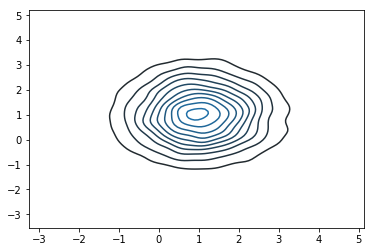

In [58]:
doc2vec_regional_indexes = wl.get_doc2vec_region_wines(
                        region_name,
                        topn=10,
                        method='mean',
                        desc=None,
                        weight=1)

In [57]:
region_name = 'Brouilly'

In [59]:
doc2vec_regional_indexes

([119745, 71535, 129597, 67040, 113705, 29426, 796, 122493, 32180, 121467],
 array([[ 0.26910132,  0.24135132, -0.17267655,  0.32080564, -0.00156734,
          0.07468286, -0.18208379,  0.24184507,  0.17980805, -0.12393317,
          0.1467229 ,  0.37877038, -0.08807872, -0.32824105,  0.32884806,
          0.18919677,  0.03891424, -0.19989054, -0.37681061,  0.02857148,
          0.09895596,  0.01131906,  0.33999047,  0.03422703,  0.14593235,
         -0.11903102,  0.11641189,  0.096659  ,  0.38340616,  0.00228046,
         -0.06111437,  0.39367715, -0.0332485 ,  0.14792542, -0.14350007,
          0.00304228, -0.12802161, -0.12098645, -0.28745112, -0.16279903]]))